# Projet Wallmart

Ce notebook présente le code nécessaire à la réalisation du projet.

In [1]:
# Début du chrono : Lancement de l'algo

from datetime import datetime
start = datetime.now()

print(f"Lancement de l'algorithme : {start}")

Lancement de l'algorithme : 2023-08-21 19:29:17.285192


# Exploration et preprocessing

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

df = pd.read_csv('Walmart_Store_sales.csv')
print('Dataset correctement enregistré dans le dataframe df')

Dataset correctement enregistré dans le dataframe df


### Aperçu des données

Chaque ligne correspond à la déclaration du chiffre d'affaires hebdomadaire pour un magasin, complétée par des données exogènes telles que :
* la date,
* les vacances (Holiday_Flag),
* la température,
* le prix de l'essence (Fuel_Price),
* et le nombre de chômeurs (Unemployment)


In [3]:
display(df)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
...,...,...,...,...,...,...,...,...
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


Nous avons des données réparties sur **150 lignes** et **8 colonnes**.


### Structure des données
En analysant la description des données et les informations de colonnes, on peut déjà voir l'objectif de Wallmart.

L'entreprise souhaite voir la relation entre les ventes et les indicateurs suivants : Holiday, Temperature, Prix du carburant, Indice des prix à la consommation (CPI) et le taux de chômage.

In [4]:
df.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


On compte **entre 12 et 18 valeurs** manquantes par colonne (hors Store à 0)

Pour chaque feature, il conviendra d'analyser la répartition des valeurs manquantes et comment les traiter (suppression vs. estimation).

In [5]:
df.isna().sum()

Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

## Variable target : Weekly_Sales

### Valeurs manquantes
Il y a 14 mesures (lignes) pour lesquelles on n'a pas le chiffre d'affaires.

In [6]:
# La variable Target est 'Weekly_Sales'
missing_sales = len(df[df['Weekly_Sales'].isna()])
missing_sales

14

On supprime les lignes pour lesquelles le chiffre d'affaires (target) n'est pas renseignée.

In [7]:
df = df.dropna(subset = ['Weekly_Sales'])

missing_sales = len(df[df['Weekly_Sales'].isna()])
if missing_sales == 0:
    print("Il n'y a plus de valeurs manquantes dans la colonne Weekly_Sales")

Il n'y a plus de valeurs manquantes dans la colonne Weekly_Sales


### Lien avec les features
* La variable target **Weekly_Sales** est la plus corrélée avec la feature **Store**.

<ipython-input-8-0ffe45e50af8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


<Axes: >

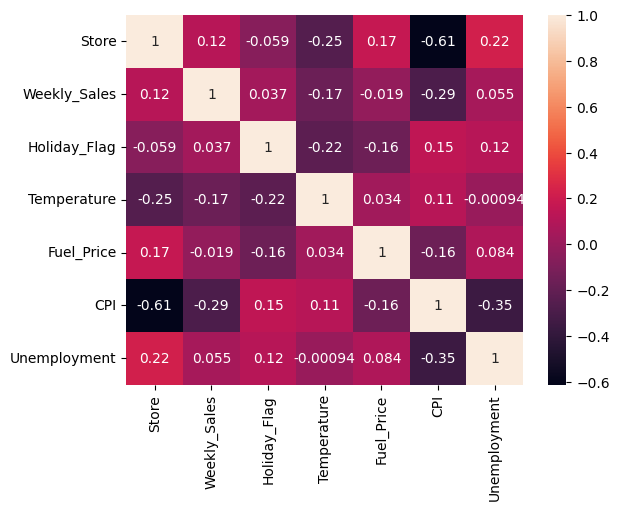

In [8]:
df_corr = df.corr()
sns.heatmap(df_corr, annot=True)

**Piste d'explication**

Cet id ***Store*** est informatif mais il y a une corrélation avec le chiffre d'affaires.

Le chiffre d'affaires d'un magasin est corrélé à sa sa surface de vente, qui elle-même conditionne le volume d'investissements, publicitaires par exemple.

On a peut-être affaire à des magasins hétérogènes. On peut mesurer cette hétérogénéité grâce au chiffre d'affaires.

In [9]:
week_sales_store = df['Weekly_Sales'].groupby(df['Store']).count().sort_values(ascending=False)
week_sales_store

Store
3.0     12
18.0    10
1.0      9
14.0     9
13.0     9
5.0      8
7.0      8
19.0     8
2.0      8
17.0     7
4.0      6
6.0      6
8.0      6
20.0     5
12.0     5
10.0     5
15.0     4
16.0     4
9.0      4
11.0     3
Name: Weekly_Sales, dtype: int64

Nous avons des magasins qui ont bien transmis leur chiffre d'affaires mais vraiment pas tous :
* Maximum : Le magasin n°3 a transmis 12 chiffres d'affaires
* Minimum : En comparaison, le magasin n°11 n'a transmis que 3 chiffres d'affaires.

In [10]:
# Transformer les IDs de float à integer
df['Store'] = df['Store'].astype(int)

Voyons graphiquement le CA hebdomadaire moyen par magasin
* Les ventes hebdomadaires en valeur moyenne semblent montrer plusieurs paliers sur le graphique.

Cela confirme donc le caractère très hétérogène des magasins.


In [11]:
# Calcul du chiffre d'affaires moyen par magasin
store_ca_mean = df['Weekly_Sales'].groupby(df['Store']).mean().sort_values(ascending=False)
store_ca_mean = pd.DataFrame(store_ca_mean).reset_index()

In [12]:
store_ca_mean

,Store,Weekly_Sales
0,4,2.173759e+06
1,14,2.092878e+06
2,13,1.997235e+06
3,20,1.962384e+06
4,2,1.943034e+06
5,10,1.822106e+06
6,1,1.562508e+06
7,6,1.551124e+06
8,11,1.523747e+06
9,19,1.400615e+06


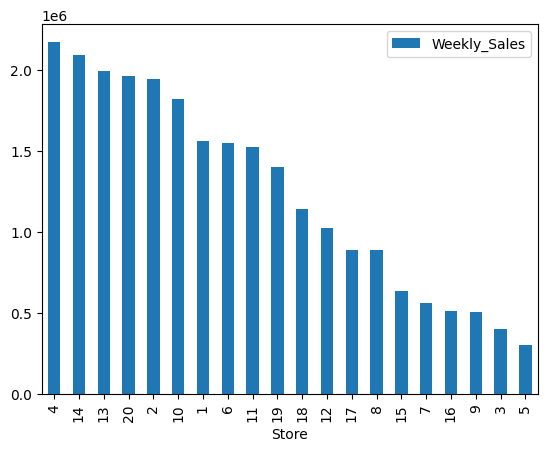

In [13]:
# On affiche le chiffre d'affaires hebdomadaire moyen par magasin
import matplotlib.pyplot as plt
store_ca_mean.plot(x="Store", y="Weekly_Sales", kind="bar")
plt.show()

### Conclusions
* La variable Target est indispensable à la mesure. On a déjà supprimé les lignes ou la target est manquante
* Un premier modèle (Baseline) sera donc lancé sur la target ***Weekly_Sales*** avec la variable ***Store***.
* Le graphique semble montrer 3 ou 4 paliers de CA
* Maximum : **2 magasins dépassent les 2 millions** de dollars hebdomadaires
* Minium : **2 magasins sont sous la barre des 500000$** en moyenne

## Store : IDs des magasins

La feature Store identifie chaque magasin. On peut donc la considèrer comme un identifiant (id) :
* 2 magasins ont plus de 10 mesures,
* 7 magasins entre 8 et 9 mesures,
* 10 magasins avec moins de 7 mesures

Il faudra en tenir compte en termes de preprocessing en fonction des axes d'analyses

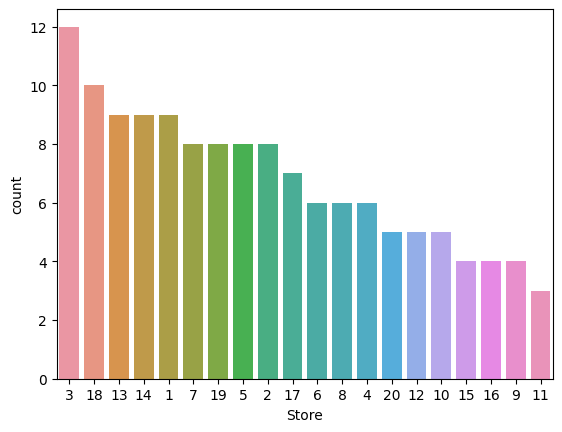

In [14]:
# Afficher le nombre de mesures (lignes) par magasin
sns.countplot(x=df['Store'], order=df['Store'].value_counts().index)
print()

## Date

**Valeurs manquantes :** Il manque 18 dates.
**Preprocessing :** Supprimer les dates manquantes.

In [15]:
missing_date = df['Date'].isna().sum()
missing_date

18

In [16]:
# Preprocessing : suppression des lignes dont la date est manquante
df = df.dropna(subset = ['Date'])

missing_sales = len(df[df['Date'].isna()])
if missing_sales == 0:
    print("Il n'y a plus de valeurs manquantes dans la colonne Date")

Il n'y a plus de valeurs manquantes dans la colonne Date


La feature ***Date*** doit être convertie au format datetime.

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

<ipython-input-17-a8fdb6136c2a>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-17-a8fdb6136c2a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


0     2011-02-18
1     2011-03-25
4     2010-05-28
5     2010-05-28
6     2011-03-06
         ...    
144   2012-10-19
145   2010-06-18
147   2010-11-06
148   2011-12-08
149   2012-04-20
Name: Date, Length: 118, dtype: datetime64[ns]

In [18]:
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

**Preprocessing**

Nous allons manipuler les dates. Pour ce faire, nous allons extraire de la date les jours, mois, année et jour de la semaine (du lundi au dimanche).

In [19]:
# Extraire year, month, day et day_week de la Date

from datetime import datetime
df['year'] = df['Date'].dt.year.astype('int32') # 0 pour lundi jusqu'à 6 pour dimanche
df['month'] = df['Date'].dt.month.astype('int32')
df['day'] = df['Date'].dt.day.astype('int32')
df['day_week'] = df['Date'].dt.weekday.astype('int32') # 0 pour lundi jusqu'à 6 pour dimanche

df.head()

<ipython-input-19-2e0c3a20963c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['Date'].dt.year.astype('int32') # 0 pour lundi jusqu'à 6 pour dimanche
<ipython-input-19-2e0c3a20963c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['Date'].dt.month.astype('int32')
<ipython-input-19-2e0c3a20963c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,day_week
0,6,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
4,6,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
5,4,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28,4
6,15,2011-03-06,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,3,6,6


In [20]:
# Maintenant que nous avons extrait nos informations de Date, supprimer la feature Date
df= df.drop('Date', axis=1)
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,day_week
0,6,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
4,6,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
5,4,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28,4
6,15,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,3,6,6


# Preprocessing

Nous allons réaliser les autres opération de preprocessing utiles aux résultats du machine learning.

In [21]:
# Suppression des outliers sur les colonnes Temperature, Fuel_Price, CPI et Unemployment

print('Before preprocessing : ', df.shape[0])
print('Dropping outliers in Temperature...')
mask_min = df['Temperature'] > df['Temperature'].mean() - 3*df['Temperature'].std()
mask_max = df['Temperature'] < df['Temperature'].mean() + 3*df['Temperature'].std()
df=df.loc[mask_min & mask_max]
print('After preprocessing : ', df.shape[0])

print('---')

print('Dropping outliers in Fuel_price...')
mask_min = df['Fuel_Price'] > df['Fuel_Price'].mean() - 3*df['Fuel_Price'].std()
mask_max = df['Fuel_Price'] < df['Fuel_Price'].mean() + 3*df['Fuel_Price'].std()
df=df.loc[mask_min & mask_max]
print('After preprocessing : ', df.shape[0])

print('---')

print('Dropping outliers in CPI...')
mask_min = df['CPI'] > df['CPI'].mean() - 3*df['CPI'].std()
mask_max = df['CPI'] < df['CPI'].mean() + 3*df['CPI'].std()
df=df.loc[mask_min & mask_max]
print('After preprocessing : ', df.shape[0])

print('---')

print('Dropping outliers in Unemployment...')
mask_min = df['Unemployment'] > df['Unemployment'].mean() - 3*df['Unemployment'].std()
mask_max = df['Unemployment'] < df['Unemployment'].mean() + 3*df['Unemployment'].std()
df=df.loc[mask_min & mask_max]
print('After preprocessing : ', df.shape[0])

print('---')
df.head()

Before preprocessing :  118
Dropping outliers in Temperature...
After preprocessing :  107
---
Dropping outliers in Fuel_price...
After preprocessing :  96
---
Dropping outliers in CPI...
After preprocessing :  91
---
Dropping outliers in Unemployment...
After preprocessing :  80
---


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,day_week
0,6,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
4,6,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
6,15,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,3,6,6
7,20,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,3,2,4


In [22]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'

print("Separating labels from features...")
Y = df.loc[:,target_name]
X = df.drop(target_name, axis = 1) # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()


Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0      6           NaN        59.61       3.045  214.777523         6.858   
1     13           0.0        42.38       3.435  128.616064         7.470   
4      6           0.0        78.89       2.759  212.412888         7.092   
6     15           0.0        69.80       4.069  134.855161         7.658   
7     20           0.0        39.93       3.617  213.023622         6.961   

   year  month  day  day_week  
0  2011      2   18         4  
1  2011      3   25         4  
4  2010      5   28         4  
6  2011      3    6         6  
7  2012      3    2         4  



In [23]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [24]:
# Identification des colonnes par nature (numeric vs categorical)
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day', 'day_week']
categorical_features = ['Store', 'Holiday_Flag']


In [25]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [26]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()


Performing preprocessings on train set...
    Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
6      15           0.0        69.80       4.069  134.855161         7.658   
38      4           0.0        81.85       3.570  129.066300         5.946   
12      7           0.0        36.61       3.767  192.826069         8.595   
44      1           1.0        38.51       2.548  211.242170         8.106   
66     18           0.0        73.67       2.792  132.614193         9.342   

    year  month  day  day_week  
6   2011      3    6         6  
38  2011      6   24         4  
12  2011      5   13         4  
44  2010     12    2         3  
66  2010      6    8         1  
...Done.
[[ 0.58589224  1.56199819 -1.05536176  0.30814094  0.18751465 -1.00659072
  -1.10218284  1.66003771  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.     

# Part 2 : Baseline model (linear regression)

## Entrainement du modèle

In [27]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")


Train model...
...Done.


## Résultats

In [28]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()


Predictions on training set...
...Done.
[ 651493.81899819 2110209.87303755  492019.7484825  1607928.28096959
 1127045.32066544 2116702.4476431  2479571.00732767 1224996.02094687
 1974800.97794184  455887.27735348  971866.46189959 1757242.51
 1110414.8705366   321266.26557136 2192710.73274506 2179083.59808806
 1916812.74       2002470.11185956  220368.17801145  670360.09295385
 2366297.19688972  466047.18290617 1559230.99729743  464605.32264652
  452187.19600103 1860207.75515972 1920461.54362369 2016372.45464064
  503224.30554573 1446196.89884879 1543597.44116582  625491.5861819
 1499874.82700991  566417.4751967   884328.95538675 1902869.87797706
  871555.55767955 1585511.3241074  2103568.78049736 1339088.39760039
  796043.85898706 1422184.59351514  849763.86382326  574595.98430018
 1336756.99207888 1564814.30859517 1662155.99786458 1109212.03341122
  475875.15104681  896642.77573504 1937105.50675222 1893500.93202294
  950839.43337832  443037.21839068  185350.37908239 2036968.10162772
 

In [29]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


Predictions on test set...
...Done.
[1767234.93053277 1924907.03888409 1421598.43851904  617840.09352056
 1537224.87294037 2007738.70807569   80847.06263501  472796.03134076
 1718768.32926836  647521.93680426  550747.45981996  542956.02855552
 1597394.28905389 2152078.33842004  563476.80137358 1982412.44360316]



In [30]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))


R2 score on training set :  0.9829439767913897
R2 score on test set :  0.9645679134109512


Plus le R2 est élevé, plus le modèle est performant. Ici, on obtient un R2 score supérieur à 95%. Les résultats sont bons. Le R2 sur le test set reste élevé. Il y a un espoir de généralisation mais peut-être un risque d'overfiting.

In [31]:
# List coef
regressor.coef_

array([  -44593.90018778,   -69516.09229283,  1991529.07211429,
        -109220.47078159,  -157826.70885608,    10504.10725047,
         -42867.3597865 ,   -22404.27816909,   269195.03541224,
       -1493989.14641327,  4860302.73144682, -1492024.03379353,
         -67579.93387905,   146577.67075828, -1031000.48289943,
       -1451303.88780866,  4824874.86318978,   137078.26225616,
        4763274.17105201,  2113395.0473859 ,  3291830.2827096 ,
         -88116.25492958,  3420934.87701132,  3643171.77822475,
        3966507.6919506 ,   740609.53017833,  -180775.78666184,
         -21454.5621698 ])

In [32]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

print("Names of columns corresponding to each coefficient: ", column_names)


Names of columns corresponding to each coefficient:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day', 'day_week', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Holiday_Flag_1.0', 'Holiday_Flag_nan']


In [33]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
coefs.sort_values('coefficients', ascending=False)

,coefficients
Store_4,4.860303e+06
Store_10,4.824875e+06
Store_13,4.763274e+06
Store_19,3.966508e+06
Store_18,3.643172e+06
Store_17,3.420935e+06
Store_15,3.291830e+06
Store_14,2.113395e+06
CPI,1.991529e+06
Store_20,7.406095e+05


In [34]:
# Compute abs() and sort values
feature_importance = abs(coefs)
feature_importance = feature_importance.sort_values(by = 'coefficients', ascending=False)

Voyons le résultat des coefficients en graphique.

In [35]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False,
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()


Il semble que l'identifiant des magasins joue sur le calcul du chiffre d'affaires. La première feature socio-économique arrive en 5e place : CPI (chomage).

On a un risque d'overfiting par l'ID qui peut proposer la moyenne du chiffre d'affaires au lieu de le prédire sur les features socio-économiques.

# Part 3 : Risque d'overfiting

Pour faire la lumière sur les variables pouvant directement impacter la prédiction du chiffre d'affaires, nous allons tester les régularisations :
* Ridge pour peser plus finement les coefficients selon l'importance des features
* et Lasso pour aller jusqu'à annuler les features sans importance en leur fixant un coefficient à 0.

A noter également que nous allons procéder à une GridSearch pour pouvoir comparer les 2 régularisations sur un R2 score plus fiable.

## Régularisation Ridge

In [36]:
# Perform grid search
print("Grid search...")
regressor = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.03, 0.04, 0.05] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)


Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.04}
Best R2 score :  0.7382326794120587


Avec Ridge, nous pouvons atteindre un bon taux de succès, à 0.73.

## Régularisation Lasso

In [47]:
# Précaution par rapport aux messages Warning
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Perform grid search
print("Grid search...")
regressor = Lasso()
# Grid of values to be tested
params = {
    'alpha': [51, 52, 53] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 52}
Best R2 score :  0.9133639670513704


La régularisation Lasso parvient à un R2 score de 0.91 attesté par la gridsearch. Ce score est supérieur au R2 score Ridge (0.74).

Ce modèle régularisé par Lasso est donc meilleur et peut donc être généralisé pour calculer le chiffre d'affaires avec ces features.